# Purpose

In this notebook we will look at incidence of infection, case hospitalization rate, and case fatality rate by age group.

At https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html, rates are reported only relative to the age 5-17 reference group, whereas I want the absolute rates.

# Data sources

I am using the RELATIVE rates reported at (https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html) to check my work and I am using the same data sources cited there:

1. County-level population estimates by age group, sex and race from the Vintage 2019 Census estimates (downloaded from https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata.csv 25 Apr 2021). They for some reason cite a press release about Vintage 2019 instead of a dataset and this is the closest thing I could find to the right age breakdowns.
2. Provisional COVID-19 death counts by age, sex and state (downloaded from https://data.cdc.gov/api/views/9bhg-hcku/rows.csv?accessType=DOWNLOAD 25 Apr 2021)
3. Hospitalization rates by age based on surveillance data of select counties covering about 10% of the U.S. population total (downloaded from https://gis.cdc.gov/grasp/COVIDNet/COVID19_3.html 25 Apr 2021).

We also need cases by age group, which I was able to find at the country level at https://covid.cdc.gov/covid-data-tracker/#demographics (downloaded 25 Apr 2021).

# Setup

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

deaths = pd.read_csv(
    'Provisional_COVID-19_Death_Counts_by_Sex__Age__and_State.csv',
    usecols=['Group','Year','Month','State','Sex','Age Group', 'COVID-19 Deaths']
)
deaths.columns = ['grp','yr','mo','state','sex','age','deaths']
deaths.age.replace({
    'All Ages':'all',
    'Under 1 year':'<1',
    '85 years and over':'85+'
}, inplace=True)
deaths.age = deaths.age.str.replace(' years','')

pop = pd.read_csv('cc-est2019-alldata.csv', encoding='latin1')
pop = pop[pop.YEAR == 12] # use 2019 estimate, not prior years'
pop.AGEGRP = pop.AGEGRP.map({
    0:'all',
    1:'0-4',
    2:'5-9',
    3:'10-14',
    4:'15-19',
    5:'20-24',
    6:'25-29',
    7:'30-34',
    8:'35-39',
    9:'40-44',
    10:'45-49',
    11:'50-54',
    12:'55-59',
    13:'60-64',
    14:'65-69',
    15:'70-74',
    16:'75-79',
    17:'80-84',
    18:'85+'
}) # per data dictionary at https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf
pop = pop[['STNAME','AGEGRP','TOT_POP','TOT_MALE','TOT_FEMALE']]
pop.columns = ['state','age','tot','male','female']

hosp = pd.read_csv(
    'COVID-19Surveillance_All_Data.csv', 
    skiprows=2)
hosp = hosp[(hosp.RACE == 'Overall') & (hosp.NETWORK == 'COVID-NET')]
hosp.drop(columns=['RACE','CATCHMENT','NETWORK'], inplace=True)
hosp.columns = ['yr','mmwr_yr','mmwr_wk','age','sex','cum_rate','weekly_rate']
hosp.age.replace({
    'Overall':'all',
    '< 18':'<18',
    '>= 18':'>=18'
}, inplace=True)
hosp.age = hosp.age.str.replace(' yr','')
hosp.dropna(how='all', inplace=True)
hosp = hosp[~hosp.age.isin(['all','18-49','65+','<18','>=18'])]
hosp['Wk'] = hosp.apply(
    lambda row: '%d_%02d' % (row.mmwr_yr, row.mmwr_wk),
    axis=1
)
hosp.drop(columns=['yr','mmwr_yr','mmwr_wk','sex'], inplace=True)

cases = pd.read_csv('cases_by_age_group.csv', skiprows=2)
cases.columns = ['age','percent_of_cases','count_of_cases','percent_of_US_pop']
cases.age = cases.age.str.replace(' Years','')

# Reproducing normalized rate ratios and computing case hospitalization and case fatality rates

Age breakdowns in each file:

In [18]:
print('pop:', list(pop.age.unique()))
print('cases:', list(cases.age.unique()))
print('hosp:', list(hosp.age.unique()))
print('deaths:', list(deaths.age.unique()))

pop: ['all', '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85+']
cases: ['0-4', '5-17', '18-29', '30-39', '40-49', '50-64', '65-74', '75-84', '85+']
hosp: ['0-4', '5-17', '50-64', '65-74', '75-84', '85+', '18-29', '30-39', '40-49']
deaths: ['all', '<1', '0-17', '1-4', '5-14', '15-24', '18-29', '25-34', '30-39', '35-44', '40-49', '45-54', '50-64', '55-64', '65-74', '75-84', '85+']


We need 0-4, 5-17, 18-29, 30-39, 40-49, 50-64, 65-74, 75-84, 85+ in order to reproduce the rates we're after. Cases and hospitalizations already have these categories although they have extras and are out of order. Need to fix up population and deaths more.

In [19]:
ages = ['0-4','5-17','18-29','30-39','40-49','50-64','65-74','75-84','85+']
cases = cases[cases.age.isin(ages)]
hosp = hosp[hosp.age.isin(ages)]

For population, we need to collapse a few categories (e.g. 75-79 and 80-84) and we need to split up 15-19 into 15-17 and 18-19. According to https://data.census.gov/cedsci/table?q=population%20by%20age&tid=ACSST1Y2019.S0101 (accessed 26 Apr 2021), there are 72,967,785 persons under 18.

In [20]:
pop_by_age = pop[pop.age != 'all'].drop(
    columns=['state','male','female']
).groupby('age').sum()
pop_by_age.loc['18-19'] = pop_by_age.loc[['0-4','5-9','10-14','15-19']].sum()\
                        - 72967785
pop_by_age.loc['5-17'] = pop_by_age.loc[['5-9','10-14','15-19']].sum()\
                       - pop_by_age.loc['18-19']
pop_by_age.loc['18-29'] = pop_by_age.loc[['18-19','20-24','25-29']].sum()
pop_by_age.loc['30-39'] = pop_by_age.loc[['30-34','35-39']].sum()
pop_by_age.loc['40-49'] = pop_by_age.loc[['40-44','45-49']].sum()
pop_by_age.loc['50-64'] = pop_by_age.loc[['50-54','55-59','60-64']].sum()
pop_by_age.loc['65-74'] = pop_by_age.loc[['65-69','70-74']].sum()
pop_by_age.loc['75-84'] = pop_by_age.loc[['75-79','80-84']].sum()
pop_by_age = pop_by_age.reindex(ages)

For deaths, we need to create the 0-4 and 5-17 categories.

In [21]:
deaths_by_age = deaths[
    (deaths.state == 'United States') &
    (deaths.sex == 'All Sexes') &
    (deaths.grp == 'By Total')
].drop(columns=['state','sex','grp','yr','mo']).set_index('age')
deaths_by_age.loc['0-4'] = deaths_by_age.loc[['<1','1-4']].sum()
deaths_by_age.loc['5-17'] = deaths_by_age.loc['0-17']\
                          - deaths_by_age.loc['0-4']
deaths_by_age = deaths_by_age.reindex(ages)

## Cases

The cases data already has the right age buckets. What is displayed at https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html is 

$\frac{\text{incidence of infection for given age group}}
      {\text{incidence of infection for 5-17 age group}}.$
      
In other words, this is

$\frac{\text{# people in given age group who got COVID}}
      {\text{# people in given age group}} \times
 \frac{\text{# people in 5-17 age group}}
      {\text{# people in 5-17 age group who got COVID}},$
      
which we can also write as

$\frac{\text{# people in given age group who got COVID}}
      {\text{# people in 5-17 age group who got COVID}} \times
 \frac{\text{# people in 5-17 age group}}
      {\text{# people in given age group}}$
      
and furthermore as

$\frac{\text{# people in given age group who got COVID}/
       \text{total COVID cases}}
      {\text{# people in 5-17 age group who got COVID}/
       \text{total COVID cases}} \times
 \frac{\text{# people in 5-17 age group}/
       \text{total U.S. population}}
      {\text{# people in given age group}/
       \text{total U.S. population}}$
       
which reduces to

$\frac{\text{percent of COVID cases from given age group}}
      {\text{percent of COVID cases from 5-17 age group}} \times
 \frac{\text{percent of population in 5-17 age group}}
      {\text{percent of population in given age group}}$
      
and can be computed easily from the cases dataframe as

$\frac{\text{percent of COVID cases from given age group}}
      {\text{percent of population in given age group}}
 \times
 \frac{\text{percent of population in 5-17 age group}}
      {\text{percent of COVID cases from 5-17 age group}}.$

In [22]:
cases = cases.set_index('age')
tmp = cases['percent_of_cases']/cases['percent_of_US_pop']
cases['rates'] = tmp/tmp.loc['5-17']
cases['rates_rounded'] = np.round(cases['rates'])

In [23]:
cases[['rates','rates_rounded']]

,rates,rates_rounded
age,,
0-4,0.543333,1.0
5-17,1.000000,1.0
18-29,2.226341,2.0
30-39,1.980148,2.0
40-49,1.974553,2.0
50-64,1.731875,2.0
65-74,1.290417,1.0
75-84,1.297347,1.0
85+,1.874500,2.0


The rounded values above match the values in the table at https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html.

However, I'm interested in knowing the following: what is the absolute incidence rate for each age group? In order to calculate this, we can simply calculate the incidence rate for the 5-17 age group. Then, multiplying each rate above by this incidence rate gives us the absolute incidence rate for each age group.

In [24]:
num_cases_5_17 = cases.loc['5-17', 'count_of_cases']
total_persons_5_17 = pop_by_age.loc['5-17','tot']
incidence_5_17 = num_cases_5_17/total_persons_5_17
cases['infection_incidence'] = cases['rates']*incidence_5_17
cases[['infection_incidence']]

,infection_incidence
age,
0-4,0.025331
5-17,0.046622
18-29,0.103797
30-39,0.092319
40-49,0.092058
50-64,0.080744
65-74,0.060162
75-84,0.060485
85+,0.087393


## Hospitalizations

This picture looks just like the one at https://gis.cdc.gov/grasp/COVIDNet/COVID19_3.html.

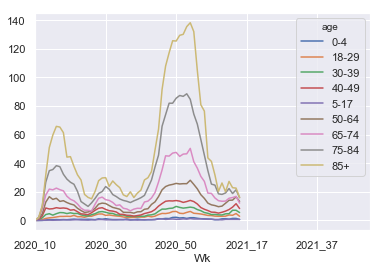

In [25]:
hosp.pivot(index='Wk', columns='age', values='weekly_rate').plot()

However I think we care about the cumulative cases.

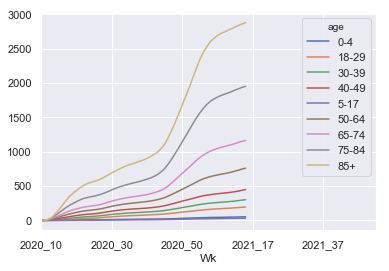

In [26]:
hosp.pivot(index='Wk', columns='age', values='cum_rate').plot()

Moreover I'm guessing the rates are based on the latest available cumulative rates.

In [27]:
hosp.Wk[hosp.cum_rate.notnull()].max()

'2021_15'

In [28]:
latest_hosp = hosp[hosp.Wk == '2021_15'].drop(
    columns=['Wk']).set_index('age').reindex(ages)
latest_hosp['rel_weekly_rate'] = latest_hosp.weekly_rate/latest_hosp.weekly_rate.loc['5-17']
latest_hosp['rel_cum_rate'] = latest_hosp.cum_rate/latest_hosp.cum_rate.loc['5-17']
latest_hosp['rel_cum_rounded'] = np.round(latest_hosp.rel_cum_rate)
latest_hosp['rel_weekly_rounded'] = np.round(latest_hosp.rel_weekly_rate)
latest_hosp

,cum_rate,weekly_rate,rel_weekly_rate,rel_cum_rate,rel_cum_rounded,rel_weekly_rounded
age,,,,,,
0-4,52.4,0.7,1.000000,1.642633,2.0,1.0
5-17,31.9,0.7,1.000000,1.000000,1.0,1.0
18-29,194.8,2.9,4.142857,6.106583,6.0,4.0
30-39,301.2,5.5,7.857143,9.442006,9.0,8.0
40-49,447.5,8.3,11.857143,14.028213,14.0,12.0
50-64,760.9,13.3,19.000000,23.852665,24.0,19.0
65-74,1163.2,12.1,17.285714,36.463950,36.0,17.0
75-84,1951.8,15.9,22.714286,61.184953,61.0,23.0
85+,2875.7,16.1,23.000000,90.147335,90.0,23.0


The rounded rates in the second to last column are similar to but not equal to the rates shown at https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html (e.g. it should be 15x for 40-49). I put in the last column just as a sanity check and that one is even more off from the rates on the web page.

But wait, they said they accessed this data on 23 Mar 2021 and it covered hospitalizations through 3/13/2021, which would be week 11. Maybe if we use that.

In [29]:
latest_hosp = hosp[hosp.Wk == '2021_11'].drop(
    columns=['Wk']).set_index('age').reindex(ages)
latest_hosp['rel_weekly_rate'] = latest_hosp.weekly_rate/latest_hosp.weekly_rate.loc['5-17']
latest_hosp['rel_cum_rate'] = latest_hosp.cum_rate/latest_hosp.cum_rate.loc['5-17']
latest_hosp['rel_cum_rounded'] = np.round(latest_hosp.rel_cum_rate)
latest_hosp['rel_weekly_rounded'] = np.round(latest_hosp.rel_weekly_rate)
latest_hosp

,cum_rate,weekly_rate,rel_weekly_rate,rel_cum_rate,rel_cum_rounded,rel_weekly_rounded
age,,,,,,
0-4,48.0,1.2,1.714286,1.655172,2.0,2.0
5-17,29.0,0.7,1.000000,1.000000,1.0,1.0
18-29,179.7,3.0,4.285714,6.196552,6.0,4.0
30-39,276.8,4.6,6.571429,9.544828,10.0,7.0
40-49,410.5,6.5,9.285714,14.155172,14.0,9.0
50-64,702.9,12.0,17.142857,24.237931,24.0,17.0
65-74,1102.8,13.5,19.285714,38.027586,38.0,19.0
75-84,1873.4,19.2,27.428571,64.600000,65.0,27.0
85+,2786.8,20.1,28.714286,96.096552,96.0,29.0


This is still not on the money. Not sure why. Anyway, according to https://gis.cdc.gov/grasp/COVIDNet/COVID19_3.html, these rates are incidence per 100,000 population. 

From this, we can calculate the fraction of each age group that has been hospitalized, by dividing the incidence per 100,000 by 100,000.

In [30]:
latest_hosp = hosp[hosp.Wk == '2021_15'].drop(
    columns=['Wk']).set_index('age').reindex(ages)
latest_hosp['cum_hosp_incidence'] = latest_hosp.cum_rate/1e5
latest_hosp[['cum_hosp_incidence']]

,cum_hosp_incidence
age,
0-4,0.000524
5-17,0.000319
18-29,0.001948
30-39,0.003012
40-49,0.004475
50-64,0.007609
65-74,0.011632
75-84,0.019518
85+,0.028757


We can also calculate the fraction of infected people from each age group who were hospitalized, as

$\frac{\text{# people hospitalized in this age group}}
      {\text{# people infected in this age group}}$, 
which we can also write as
          
$\frac{\text{# people hospitalized in this age group / total # in age group}}
      {\text{# people infected in this age group / total # in age group}}$,
which we can calculate as simply the cumulative hospital incidence from the hospital latest dataframe divided by the infection incidence column from the caess dataframe.

Text(0, 0.5, 'infected fraction hospitalized')

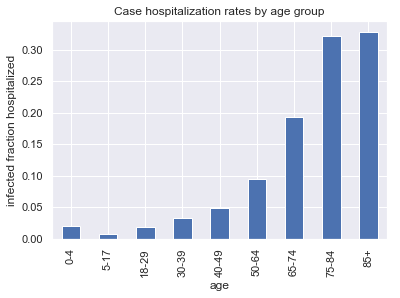

In [31]:
(latest_hosp.cum_hosp_incidence/cases.infection_incidence).plot(kind='bar')
plt.title('Case hospitalization rates by age group')
plt.ylabel('infected fraction hospitalized')

In [32]:
(latest_hosp.cum_hosp_incidence/cases.infection_incidence)

age
0-4      0.020686
5-17     0.006842
18-29    0.018767
30-39    0.032626
40-49    0.048611
50-64    0.094236
65-74    0.193344
75-84    0.322690
85+      0.329052
dtype: float64

I had also heard that the correct answer to "what are your chances of going to the hospital if you get COVID-19" is supposed to be less than 5%. Let's see if this is true overall.

In [33]:
total_hospitalizations = (latest_hosp.cum_hosp_incidence*pop_by_age.tot).sum()
total_cases = cases.count_of_cases.sum()
total_hospitalizations/total_cases

0.07187370022176338

More like 7% in terms of what's happened cumulatively. However this is in the right ballpark and I imagine chances of hospitalization have decreased somewhat over time due to the most vulnerable people being removed from the susceptible set, at least temporarily.

## Deaths

These are the total provisional death counts as of now.

In [34]:
deaths_by_age.sum()

deaths    551728.0
dtype: float64

We must first get the percentage of each age group that has died. Then we can compare rates.

In [35]:
deaths_by_age['death_rate'] = deaths_by_age.deaths/pop_by_age.tot
deaths_by_age.death_rate/deaths_by_age.death_rate.loc['5-17']

age
0-4         1.490490
5-17        1.000000
18-29      11.903118
30-39      41.998635
40-49     124.760094
50-64     415.172436
65-74    1201.833339
75-84    2970.118150
85+      7912.278328
Name: death_rate, dtype: float64

These track with what's at https://www.cdc.gov/coronavirus/2019-ncov/covid-data/investigations-discovery/hospitalization-death-by-age.html by order of magnitude but are pretty off in absolute terms. Again, not sure why. Probably using different population file than they did. Anyway, now we can compute case fatality rate by age group.

In [36]:
deaths_by_age.death_rate/cases.infection_incidence

age
0-4      0.000190
5-17     0.000069
18-29    0.000369
30-39    0.001466
40-49    0.004366
50-64    0.016565
65-74    0.064355
75-84    0.158192
85+      0.291664
dtype: float64

That's really quite high for the 85+ group... very sad. Even the 50-64 group is concerning.

# Addendum

## NJ-specific

[This article](https://www.nj.com/coronavirus/2021/05/nj-reports-10-covid-deaths-459-positive-tests-hospitalizations-cases-continue-sharp-decline.html) cited what percentage of cases/deaths were made up by each age group. I can quickly compute age-group-specific case fatality rates using these percentages along with the NJ-level case fatality rate per [Worldometer](https://www.worldometers.info/coronavirus/usa/new-jersey/) as of today. This is how:

We want:

$$\frac{\text{# of deaths among age group X}}
       {\text{# of cases among age group X}}.$$

We have:

$$\frac{\text{% of all COVID deaths that occured in age group X}}
       {\text{% of all COVID cases that occured in age group X}}.$$

To turn what we have into what we want, rewrite as follows:

\begin{align*}
 \frac{\text{% of all COVID deaths that occured in age group X}}
      {\text{% of all COVID cases that occured in age group X}}
&= \frac{\text{(# of deaths among age group X)/(total deaths)}}
        {\text{(# of cases among age group X)/(total cases)}}\\ 
&= \frac{\text{# of deaths among age group X}}{\text{# of cases among age group X}} \cdot
\frac{1}{\frac{\text{total deaths}}{\text{total cases}}}.
\end{align*}

Then given that there have been 25,810 deaths and 1,008,046 cases in NJ per Worldometer, we can multiply what we have by the ratio (total deaths)/(total cases) to obtain what we want.

In [37]:
NJ_case_fatality_rate = 25810/1008046
NJ_case_fatality_rate

0.02560399029409372

From article:

In [38]:
NJ_age_breakdown = pd.DataFrame({
    '% of infections':[0.02, 0.099, 0.199, 0.309, 0.225, 0.101, 0.044],
    '% of deaths':[0, 0, 0.004, 0.04, 0.161, 0.336, 0.459]},
    index=['0-4','5-17','18-29','30-49','50-64','65-79','80+'])

Simple manipulation to get case fatality rates by age group.

In [39]:
NJ_age_breakdown['case_fatality_rate'] =\
    (NJ_age_breakdown['% of deaths']/NJ_age_breakdown['% of infections'])*NJ_case_fatality_rate
NJ_age_breakdown

,% of infections,% of deaths,case_fatality_rate
0-4,0.020,0.000,0.000000
5-17,0.099,0.000,0.000000
18-29,0.199,0.004,0.000515
30-49,0.309,0.040,0.003314
50-64,0.225,0.161,0.018321
65-79,0.101,0.336,0.085178
80+,0.044,0.459,0.267096


This lines up pretty well with what I computed above at the national level. 

While I'm here I want to check the chances of hospitalization by age by pulling the infection and hospitalization counts from the NJ state dashboards at https://njhealth.maps.arcgis.com/apps/opsdashboard/index.html#/81a17865cb1a44db92eb8eb421703635. No way to download the underlying data as far as I can see so I'm hand-transcribing the numbers here.

In [10]:
NJ_age_breakdown['ever_hospitalized'] = [
    418, 675, 3663, 13433, 21324, 22356, 15258]
NJ_age_breakdown['confirmed_cases'] = [
    18166, 87766, 175635, 272494, 197992, 88515, 38528]
NJ_age_breakdown['case_hospitalization_rate'] =\
    NJ_age_breakdown.ever_hospitalized/NJ_age_breakdown.confirmed_cases
NJ_age_breakdown

,% of infections,% of deaths,case_fatality_rate,ever_hospitalized,confirmed_cases,case_hospitalization_rate
0-4,0.020,0.000,0.000000,418,18166,0.023010
5-17,0.099,0.000,0.000000,675,87766,0.007691
18-29,0.199,0.004,0.000515,3663,175635,0.020856
30-49,0.309,0.040,0.003314,13433,272494,0.049296
50-64,0.225,0.161,0.018321,21324,197992,0.107701
65-79,0.101,0.336,0.085178,22356,88515,0.252567
80+,0.044,0.459,0.267096,15258,38528,0.396024


If we compare the computation I did above at the national level with this it turns out to line up pretty well.

In [40]:
(latest_hosp.cum_hosp_incidence/cases.infection_incidence)

age
0-4      0.020686
5-17     0.006842
18-29    0.018767
30-39    0.032626
40-49    0.048611
50-64    0.094236
65-74    0.193344
75-84    0.322690
85+      0.329052
dtype: float64